## Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import json
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup, element
from itertools import product
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [3]:
!gdown 1z2E3GljjQ8eYvac-hPYLDk5k5PIC5WBw

Downloading...
From: https://drive.google.com/uc?id=1z2E3GljjQ8eYvac-hPYLDk5k5PIC5WBw
To: /content/OCR.zip
100% 35.7M/35.7M [00:00<00:00, 187MB/s]


In [4]:
!unzip "/content/OCR.zip" -d "/content/"
clear_output()

## Data Preprocess

In [ ]:
def get_bbox(points: str) -> list:
  temp = points.split(' ')
  x1, y1 = temp[0].split(',')
  x2, y2 = temp[1].split(',')
  x3, y3 = temp[2].split(',')
  x4, y4 = temp[3].split(',')
  bbox = [x1, y1, x2, y2, x3, y3, x4, y4]
  bbox = [int(float(i)) for i in bbox]
  return bbox


def get_word(xml_path: str) -> tuple:
  xml_path = xml_path.replace('.tif', '_ocr.xml')
  with open(xml_path, encoding='utf8') as f:
        xml_data = f.read()
  bs = BeautifulSoup(xml_data, 'xml')
  page = bs.find('Page')
  words = bs.find_all('Word')
  image_info = page.attrs
  image_word = []
  for word in words:
    temp_dict = {}
    for content in word.contents:
      temp_dict.update({'word' : word.find('Unicode').text})
      if isinstance(content,element.Tag):
        temp_dict.update(content.attrs)
    image_word.append({
      'bbox' : get_bbox(temp_dict.get('points')),
      'word' : temp_dict.get('word')
    })
  return image_info, image_word


def get_label(xml_path: str) -> list:
  xml_path = xml_path.replace('.tif', '_gt.xml')
  with open(xml_path, encoding="utf8")as f:
    xml_data = f.read()
  bs = BeautifulSoup(xml_data,'xml')
  labels = bs.find_all('TextRegion')
  image_label = []
  for label in labels:
    temp_dict = {}
    for content in label.contents:
      if isinstance(content,element.Tag):
        temp_dict.update(content.attrs)
    image_label.append({
      'bbox' : get_bbox(temp_dict.get('points')),
      'label' : temp_dict.get('value')
    })
  return image_label


def combine_word_label(image_word: list, image_label: list) -> list:
  res = []
  for row_word, row_label in product(image_word, image_label):
    x1_w, y1_w, x2_w, y2_w, x3_w, y3_w, x4_w, y4_w = row_word.get('bbox')
    x1_l, y1_l, x2_l, y2_l, x3_l, y3_l, x4_l, y4_l = row_label.get('bbox')

    if x1_w > x1_l and x2_w < x2_l and y1_w > y1_l and y4_w < y4_l:
      res.append({
          'bbox' : row_word.get('bbox'),
          'word' : row_word.get('word'),
          'label' : row_label.get('label')
      })
  return res
  

def preprocess_xml(path):
  image_info, image_word = get_word(path)
  image_label = get_label(path)
  image_axis = combine_word_label(image_word, image_label)

  image_info['annotation'] = image_axis
  return image_info

In [ ]:
path = '/content/ImageAndXML_Data'
list_img = [i for i in os.listdir(path) if '.tif' in i]
data = []

for img in list_img:
  img_path = os.path.join(path, img)
  try:
    data.append(preprocess_xml(img_path))
  except:
    print('Failed', img)

In [ ]:
# with open('/content/ImageAndXML_Data.json','w') as f:
#   json.dump(data, f, indent=4)

In [ ]:
with open('/content/ImageAndXML_Data.json') as f:
  data = json.load(f) 

In [ ]:
df = pd.DataFrame(data)

In [ ]:
path = '/content/ImageAndXML_Data/0000223278.tif'
list_bbox = [i['bbox'] for i in df[df['imageFilename']=='0000223278.tif']['annotation'].values[0]]
list_bbox = [[i[0],i[1],i[4],i[5]] for i in list_bbox]

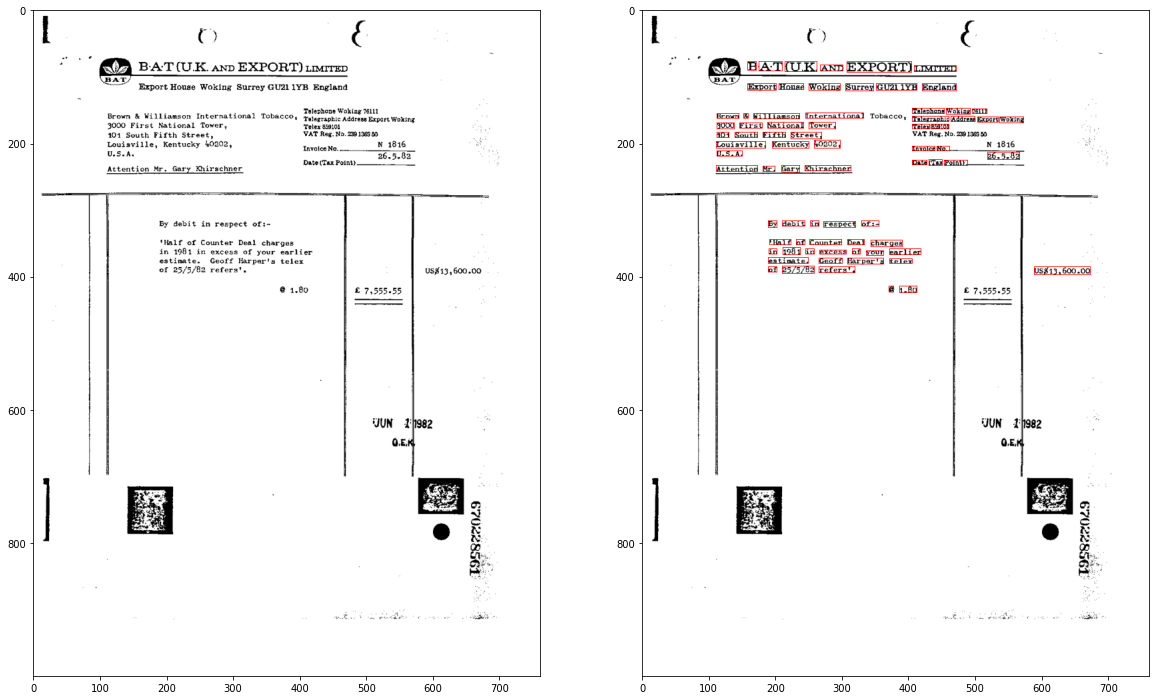

In [ ]:
f, axs = plt.subplots(1,2, figsize=(20, 20))

img = cv2.imread(path)
axs[0].imshow(img)

for x1, y1, x2, y2 in list_bbox:
  cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 1)
axs[1].imshow(img)

plt.show()

## Text Detection

### 1. Segmentation

In [ ]:
cv2.setUseOptimized(True)
ss =  cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

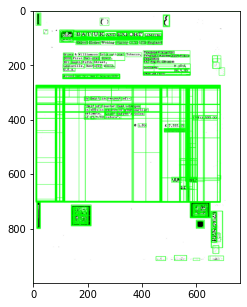

In [ ]:
im = cv2.imread(path)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(10,5))
plt.imshow(imOut)

### 2. Data Preparation

In [ ]:
cv2.setUseOptimized(True)
ss =  cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def actual_bbox(filename):
  filename = filename.split('/')[-1]
  list_bbox = [i['bbox'] for i in df[df['imageFilename']==filename]['annotation'].values[0]]
  list_bbox = [[i[0],i[1],i[4],i[5]] for i in list_bbox]
  return np.array(list_bbox)


def segment_bbox(filename):
  img = cv2.imread(filename)
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  list_bbox = ss.process()
  list_bbox =  [[i[0], i[1], i[0]+i[2], i[1]+i[3]] for i in list_bbox]
  return np.array(list_bbox)


def bb_iou(box_act, box_seg):
  x_1 = max(box_act[0], box_seg[0])
  y_1 = max(box_act[1], box_seg[1])
  x_2 = min(box_act[2], box_seg[2])
  y_2 = min(box_act[3], box_seg[3])

  inter_area = max(0, x_2 - x_1 + 1) * max(0, y_2 - y_1 + 1)
  act_area = (box_act[2] - box_act[0] + 1) * (box_act[3] - box_act[1] + 1)
  seg_area = (box_seg[2] - box_seg[0] + 1) * (box_seg[3] - box_seg[1] + 1)

  iou = inter_area / float(act_area + seg_area - inter_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou


def preprocess_train(filename):
  img = cv2.imread(filename)
  img_out = img.copy()
  bbox_actual = actual_bbox(filename)
  np.random.shuffle(bbox_actual)
  bbox_segment = segment_bbox(filename)
  np.random.shuffle(bbox_segment)
  train_data = {'filename':[], 'bbox':[], 'label':[]}
  true_count = 0
  false_count = 0
  for act, seg in product(bbox_actual, bbox_segment):
    iou = bb_iou(act, seg)
    if iou > 0.7 and true_count <= 50:
      # temp_img = img_out[seg[1]:seg[3], seg[0]:seg[2]]
      # img_res = cv2.resize(temp_img, (100,100), interpolation=cv2.INTER_AREA)
      # train_data['image'].append(img_res.tolist())
      train_data['filename'].append(filename.split('/')[-1])
      train_data['bbox'].append(seg.tolist())
      train_data['label'].append(1)
      true_count += 1
    elif iou < 0.3 and false_count <= 30:
      # temp_img = img_out[seg[1]:seg[3], seg[0]:seg[2]]
      # img_res = cv2.resize(temp_img, (100,100), interpolation=cv2.INTER_AREA)
      # train_data['image'].append(img_res.tolist())
      train_data['filename'].append(filename.split('/')[-1])
      train_data['bbox'].append(seg.tolist())
      train_data['label'].append(0)
      false_count += 1
    elif false_count > 30 and true_count > 70:
      break
  return train_data

In [ ]:
path = '/content/ImageAndXML_Data'
list_img = [i for i in os.listdir(path) if '.tif' in i]
data = {'image':[], 'label':[]}

for img in tqdm(list_img):
  img_path = os.path.join(path, img)
  try:
    temp_res = preprocess_train(img_path)
    # data['image'].extend(temp_res['image'])
    # data['label'].extend(temp_res['label'])
    with open(f"/content/data_train/{img.replace('.tif', '')}.json", 'w') as f:
      json.dump(temp_res, f, indent=4)
  except:
    print('Failed', img)

  0%|          | 0/520 [00:00<?, ?it/s]

In [ ]:
!zip -r '/content/data_train.zip' '/content/data_train'

In [ ]:
from google.colab import files
files.download('/content/data_train.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
path = '/content/data_train'
list_data = [i for i in os.listdir(path) if '.json' in i]
data = {'filename':[], 'bbox':[], 'label':[]}

for row in tqdm(list_data):
  row_path = os.path.join(path, row)
  with open(row_path) as f:
      temp = json.load(f)
  data['filename'].extend(temp['filename'])
  data['bbox'].extend(temp['bbox'])
  data['label'].extend(temp['label'])

  0%|          | 0/520 [00:00<?, ?it/s]

In [ ]:
df_train = pd.DataFrame(data)

In [ ]:
df_train

,filename,bbox,label
0,11230046.tif,"[541, 525, 744, 603]",0
1,11230046.tif,"[64, 626, 163, 629]",0
2,11230046.tif,"[197, 550, 541, 600]",0
3,11230046.tif,"[595, 575, 635, 626]",0
4,11230046.tif,"[198, 396, 406, 398]",0
...,...,...,...
38919,92173709.tif,"[360, 418, 438, 443]",1
38920,92173709.tif,"[293, 606, 332, 617]",1
38921,92173709.tif,"[291, 627, 318, 639]",1
38922,92173709.tif,"[292, 627, 317, 639]",1


In [ ]:
def bbox_array(filename, bbox, path='/content/ImageAndXML_Data'):
  filename = os.path.join(path, filename)
  img = cv2.imread(filename)
  temp_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
  img_res = cv2.resize(temp_img, (64,64), interpolation=cv2.INTER_AREA)
  return img_res

def save_train_img(df):
    name_before = ''
    idx_name = 0
    for _, row in tqdm(df.iterrows()):
      img = bbox_array(row['filename'], row['bbox'])

      if name_before == row['filename']:
        idx_name += 1
      else:
        idx_name = 0

      status = cv2.imwrite(f"/content/detection_train/{row['label']}/{row['filename'].replace('.tif', '')}_{idx_name}.png",img)
      name_before = row['filename']

In [ ]:
save_train_img(df_train)

0it [00:00, ?it/s]

In [ ]:
!zip -r '/content/detection_train.zip' '/content/detection_train'

In [ ]:
from google.colab import files
files.download('/content/detection_train.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3. Data Preprocessing

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/MLT2_Project/detection_train.zip" -d "/content"
clear_output()

In [ ]:
import random
import shutil

# make new directory split
path = '/content/content/detection_train/0'
list_dir = os.listdir(path)
random.shuffle(list_dir)
idx = int(len(list_dir)*0.9)
new_train = list_dir[:idx]
new_val = list_dir[idx:]
for i in new_train:
  shutil.copy2(os.path.join(path,i), os.path.join('/content/detection_data/train/0',i))
for i in new_val:
  shutil.copy2(os.path.join(path,i), os.path.join('/content/detection_data/test/0',i))

path = '/content/content/detection_train/1'
list_dir = os.listdir(path)
random.shuffle(list_dir)
idx = int(len(list_dir)*0.9)
new_train = list_dir[:idx]
new_val = list_dir[idx:]
for i in new_train:
  shutil.copy2(os.path.join(path,i), os.path.join('/content/detection_data/train/1',i))
for i in new_val:
  shutil.copy2(os.path.join(path,i), os.path.join('/content/detection_data/test/1',i))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image generator
def define_generator(width, height, batch_size):

  # train dataset
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2
    )

  ## split into train
  train_generator = train_datagen.flow_from_directory(
    "/content/detection_data/train/",
    target_size=(width, height),
    batch_size = batch_size,
    color_mode='rgb',
    class_mode = 'binary',
    subset='training'
  )

  ## split into validation
  validation_generator = train_datagen.flow_from_directory(
      "/content/detection_data/train/",
      target_size=(width, height),
      batch_size = batch_size,
      color_mode='rgb',
      class_mode = 'binary',
      subset='validation'
  )

  # test dataset
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

  test_generator = test_datagen.flow_from_directory(
      directory='/content/detection_data/test/',
      classes=['test'],
      target_size=(width, height),
      batch_size=1,
      color_mode='rgb',
      shuffle=False,
      class_mode='binary')

  return train_generator, validation_generator, test_generator

### 4. Build Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
def define_model(width, height):
  model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
  model_main = tf.keras.applications.vgg16.VGG16(include_top=False)(model_input)
  model_dense1 = tf.keras.layers.Flatten()(model_main)
  model_dense2 = tf.keras.layers.Dense(64, activation='relu')(model_dense1)
  model_dense3 = tf.keras.layers.Dropout(0.2)(model_dense2)
  model_out = tf.keras.layers.Dense(1, activation='sigmoid')(model_dense3)

  model = tf.keras.models.Model(model_input,  model_out)
  optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
def define_callbacks():
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath='model_detection.h5',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkpoint

In [ ]:
NB_EPOCH     = 10
BATCH_SIZE   = 256
WIDTH        = 64
HEIGHT       = 64

In [ ]:
model = define_model(WIDTH, HEIGHT)
model.summary()
train_generator, validation_generator, test_generator = define_generator(WIDTH, HEIGHT, BATCH_SIZE)
save_callback = define_callbacks()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,845,889
Trainable params: 14,845,889
Non-t

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 28026 images belonging to 2 classes.
Found 7006 images belonging to 2 classes.
Found 0 images belonging to 1 classes.


In [ ]:
history = model.fit(
  train_generator,
  epochs = NB_EPOCH,
  steps_per_epoch = train_generator.samples // BATCH_SIZE,
  validation_data = validation_generator,
  validation_steps = validation_generator.samples // BATCH_SIZE,
  callbacks = [save_callback]
)

Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8140
Epoch 1: val_accuracy improved from -inf to 0.84158, saving model to model_detection.h5
109/109 [==============================] - 58s 519ms/step - loss: 0.4227 - accuracy: 0.8140 - val_loss: 0.3679 - val_accuracy: 0.8416
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8336
Epoch 2: val_accuracy improved from 0.84158 to 0.84606, saving model to model_detection.h5
109/109 [==============================] - 56s 508ms/step - loss: 0.3879 - accuracy: 0.8336 - val_loss: 0.3596 - val_accuracy: 0.8461
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8392
Epoch 3: val_accuracy improved from 0.84606 to 0.84737, saving model to model_detection.h5
109/109 [==============================] - 56s 510ms/step - loss: 0.3734 - accuracy: 0.8392 - val_loss: 0.3632 - val_accuracy: 0.8474
Epoch 4/10
109/109 [====================

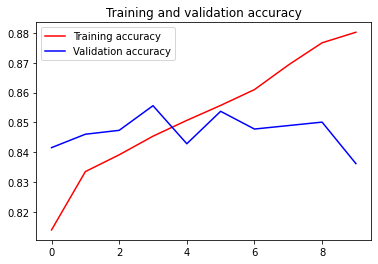

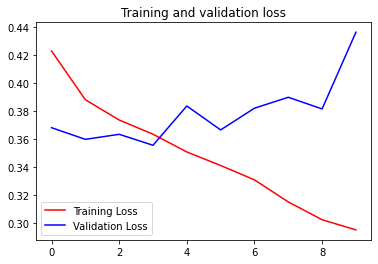

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Text Recognition

### 1. Data Preparation

In [76]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from jiwer import wer

print(tf.__version__)

2.8.2


In [ ]:
with open('/content/drive/MyDrive/MLT2_Project/ImageAndXML_Data.json') as f:
  data = json.load(f)

In [ ]:
data_parse = []
for row in data:
  for ann in row['annotation']:
    data_parse.append({
        'filename' : row['imageFilename'],
        'height' : row['imageHeight'],
        'width' : row['imageWidth'],
        'bbox' : ann['bbox'],
        'label' : ann['label'],
        'word' : ann['word']
    })

In [ ]:
data_parse[0]

{'bbox': [331, 87, 403, 87, 403, 100, 331, 100],
 'filename': '526509181+-9181.tif',
 'height': '1000',
 'label': 'invoice_info',
 'width': '754',
 'word': 'INVOICE'}

In [ ]:
def save_train_img(data):
    annot = open("/content/recognition_data/annotation.txt", "w")
    for idx, row in tqdm(enumerate(data)):
        name = row['filename']
        bbox = row['bbox']
        word = row['word']

        new_name = f"{idx}_{name.replace('.tif','')}.png"
        img = cv2.imread(f"/content/ImageAndXML_Data/{name}")
        temp_img = img[bbox[1]:bbox[-1], bbox[0]:bbox[2]]
        status = cv2.imwrite(f"/content/recognition_data/img/{new_name}", temp_img)
        annot.write(f"img/{new_name} {word}\n")
    annot.close()

In [ ]:
save_train_img(data_parse)

0it [00:00, ?it/s]

In [ ]:
# !zip -r '/content/recognition_data.zip' '/content/recognition_data'
# clear_output()

In [ ]:
# shutil.copy2('/content/recognition_data.zip', '/content/gdrive/MyDrive/MLT2_Project/recognition_data.zip')

In [ ]:
# from google.colab import files
# files.download('/content/recognition_data.zip')

In [4]:
!unzip "/content/drive/MyDrive/MLT2_Project/recognition_data.zip" -d "/content/"
clear_output()

### 2. Data Preprocess

In [77]:
with open('/content/content/recognition_data/annotation.txt','r') as f:
    data_rec = f.readlines()
df_rec = pd.DataFrame([i.replace('\n','').split(' ') for i in data_rec])
df_rec.columns = ['filename', 'label']
df_rec = df_rec[df_rec['label'].apply(lambda x: len(x))<=30].reset_index(drop=True)
df_rec['filename'] = ['/content/content/recognition_data/'+i for i in df_rec['filename'].to_list()]

In [78]:
df_rec = df_rec.sample(frac=1).reset_index(drop=True)
split = int(len(df_rec) * 0.85)
df_train = df_rec[:split]
df_val = df_rec[split:]

In [79]:
characters = df_rec['label'].str.split('').explode().value_counts().index[1:].to_list()

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [80]:
WIDTH        = 64
HEIGHT       = 64

def encode_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    label = char_to_num(label)
    return img, label

In [81]:
BATCH_SIZE = 128
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train['filename']), list(df_train['label']))
)
train_dataset = (
    train_dataset.map(encode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["filename"]), list(df_val['label']))
)
validation_dataset = (
    validation_dataset.map(encode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### 3. Build Model

In [82]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [83]:
class CTCLayer(tf.keras.layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")


        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [90]:
def define_model(width, height, num_classes):
    # convolutional
    model_input = tf.keras.layers.Input(shape=[64, 64, 3], name='image')
    model_main = tf.keras.applications.vgg16.VGG16(include_top=False)(model_input)
    model_dense1 = tf.keras.layers.Reshape((-1, 512), name='flatten7')(model_main)

    # residual
    model_dense2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=256, return_sequences=True), name='bi_lstm1')(model_dense1)
    model_dense3 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=256, return_sequences=True), name='bi_lstm2')(model_dense2)
    model_dense4 = tf.keras.layers.Dense(units=num_classes, name='logits')(model_dense3)
    model_out = tf.keras.layers.Dense(units=num_classes + 1, activation="softmax")(model_dense4)

    model = tf.keras.models.Model(inputs=model_input, outputs=model_out, name='crnn')
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss=CTCLoss)
    return model

In [91]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [92]:
def define_callbacks():
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath='/content/drive/MyDrive/MLT2_Project/model_recognition.h5',
      monitor='val_loss',
      mode='min',
      verbose=1
  )

  validation_callback = CallbackEval(validation_dataset)
  return [checkpoint, validation_callback]

In [93]:
NB_EPOCH     = 10

In [96]:
NUM_CLASS = char_to_num.vocabulary_size()
model = define_model(WIDTH, HEIGHT, NUM_CLASS)
model.summary()
save_callback = define_callbacks()

Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten7 (Reshape)          (None, 4, 512)            0         
                                                                 
 bi_lstm1 (Bidirectional)    (None, 4, 512)            1574912   
                                                                 
 bi_lstm2 (Bidirectional)    (None, 4, 512)            1574912   
                                                                 
 logits (Dense)              (None, 4, 118)            60534     
                                                                 
 dense (Dense)               (None, 4, 119)            14161  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [98]:
history = model.fit(
  train_data,
  epochs = NB_EPOCH,
  steps_per_epoch = 100,
  validation_data = val_data,
  validation_steps = 100,
  callbacks = save_callback
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


ValueError: ignored